Note: you may need to restart the kernel to use updated packages.
LOADING RAW DATA
Note: you may need to restart the kernel to use updated packages.
LOADING RAW DATA
Starting with: 11175 cells × 58690 genes

CELL FILTERING
filtered out 8 cells that have less than 200 genes expressed
Starting with: 11175 cells × 58690 genes

CELL FILTERING
filtered out 8 cells that have less than 200 genes expressed
After min_genes=200: 11167 cells
filtered out 32 cells that have more than 5000 genes expressed
After min_genes=200: 11167 cells
filtered out 32 cells that have more than 5000 genes expressed
After max_genes=5000: 11135 cells
After max_genes=5000: 11135 cells
After pct_mt<20: 11135 cells

Cells removed: 40 (0.4%)

GENE FILTERING
filtered out 36131 genes that are detected in less than 3 cells
After pct_mt<20: 11135 cells

Cells removed: 40 (0.4%)

GENE FILTERING
filtered out 36131 genes that are detected in less than 3 cells
Genes before: 58690
Genes after:  22559
Genes removed: 36131 (61.6%)

/home/vicky/miniconda3/envs/scrnaseq/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


Highly variable genes selected: 3000
Saved: figures/05_hvg_selection.png
Saved: figures/05_hvg_selection.png


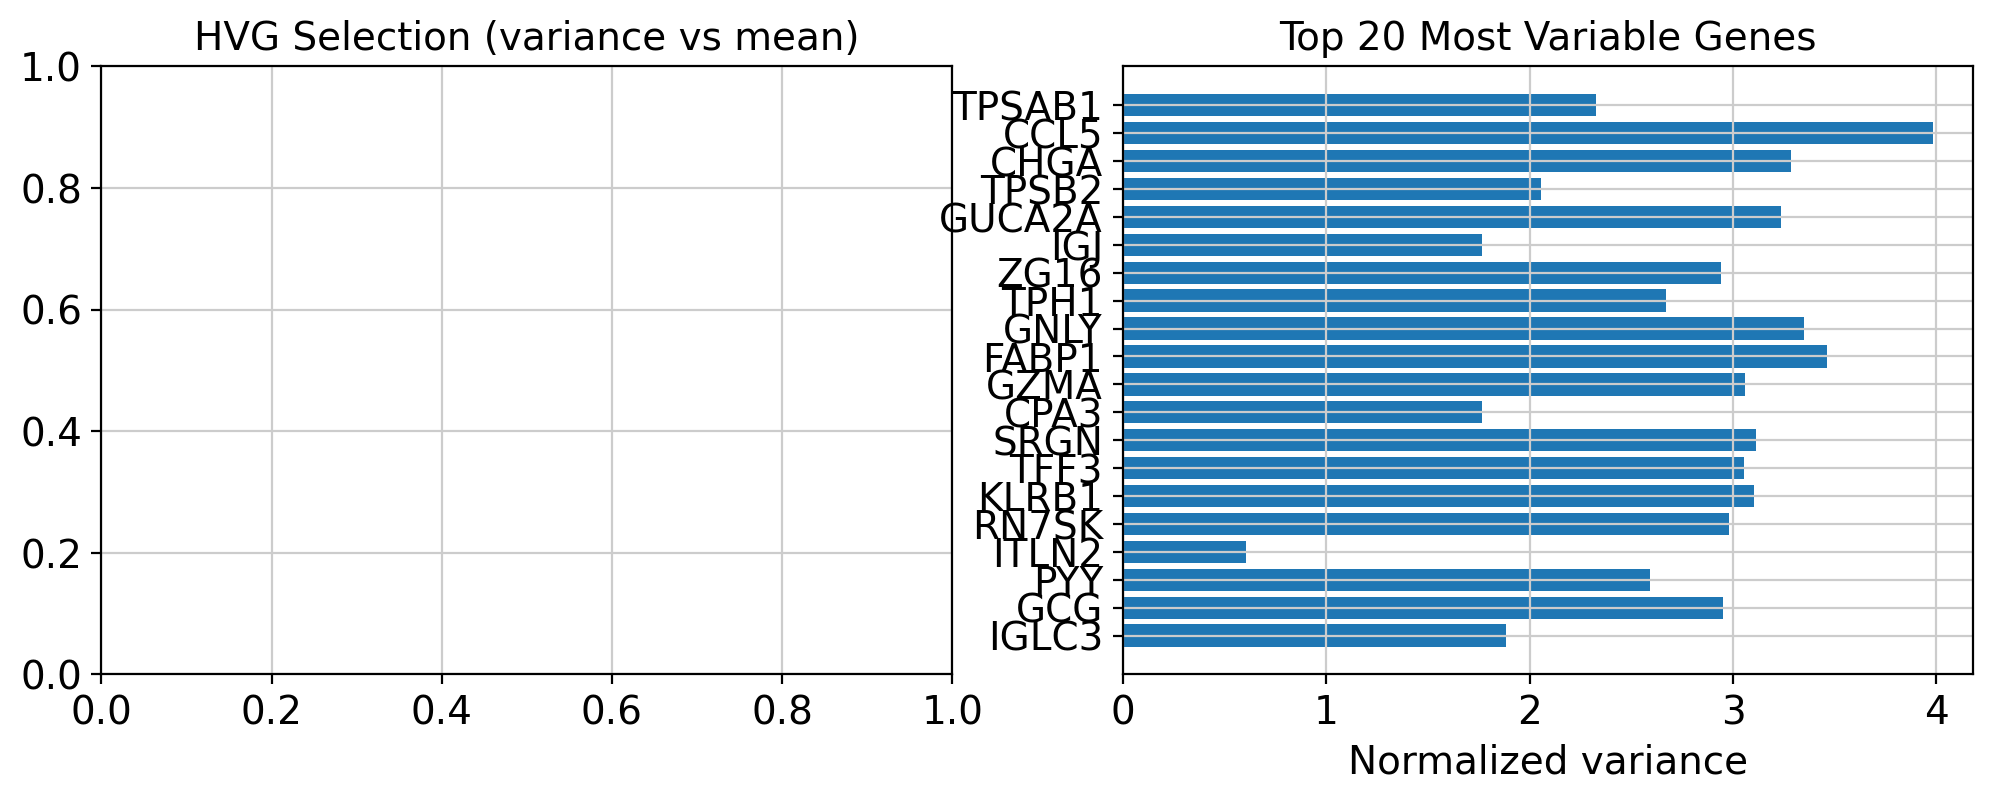

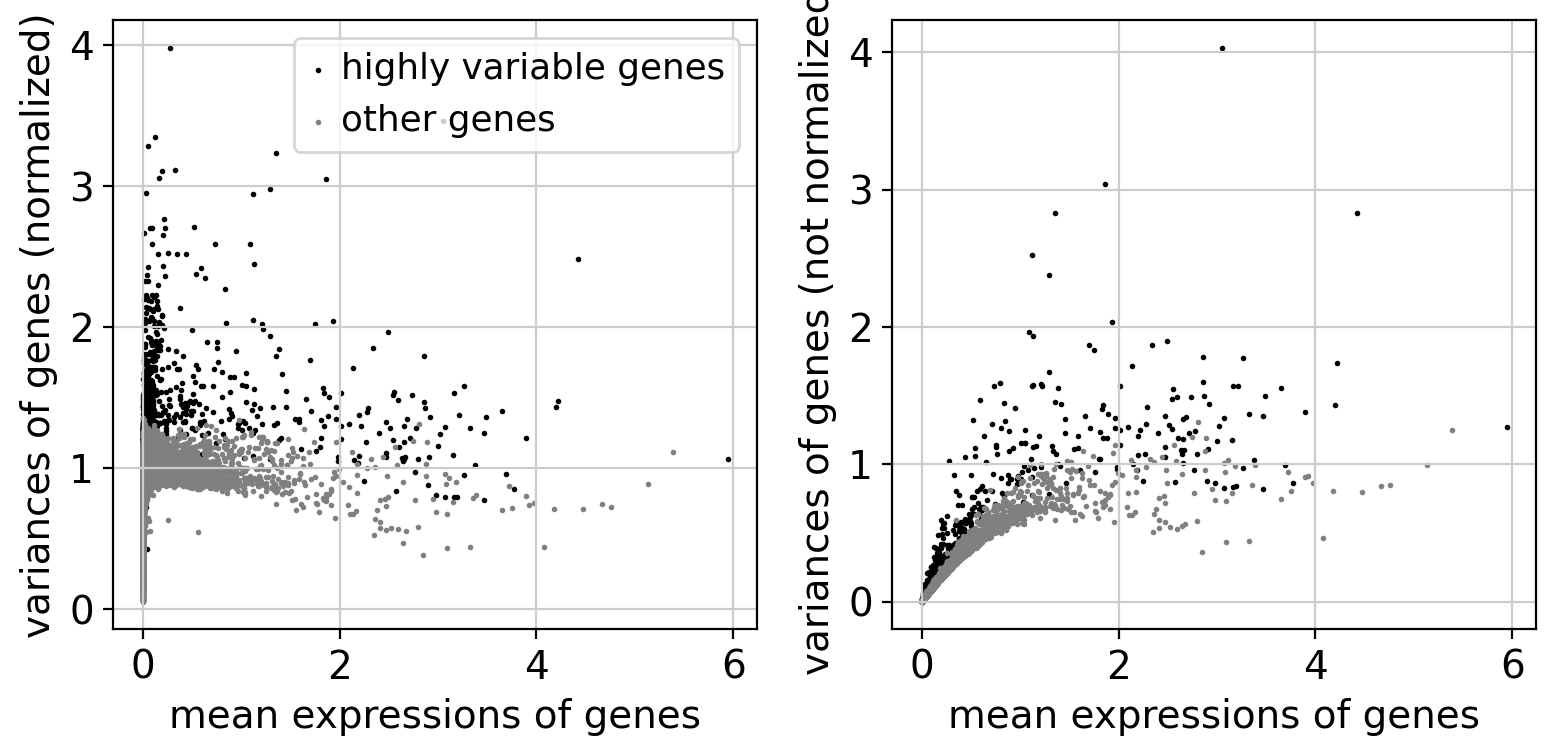


SAVING PREPROCESSED DATA
Full dataset saved: data/processed/GSE116222_preprocessed.h5ad
Full dataset saved: data/processed/GSE116222_preprocessed.h5ad
HVG subset saved: data/processed/GSE116222_hvg.h5ad

PREPROCESSING SUMMARY

Data transformation pipeline:
  Raw counts → Filtered → Normalized → Log-transformed

Final dimensions:
  Cells: 11135
  All genes: 22559
  HVG subset: 3000

Layers stored:
  adata.X = log-normalized expression
  adata.layers['counts'] = raw counts (for DE analysis)

Key annotations:
  adata.var['highly_variable'] = HVG boolean mask
  adata.var['highly_variable_rank'] = HVG ranking

Files created:
  GSE116222_preprocessed.h5ad - Full gene set
  GSE116222_hvg.h5ad - HVG subset only

Next step: Week 3 - Dimensionality Reduction & Clustering

SANITY CHECKS

Post-normalization total counts per cell:
  Before log: should be ~10,000
  After log: varies (log compressed)
  EPCAM: ✓ HVG
  KRT20: ✓ HVG
  MUC2: ✓ HVG
  BEST4: ✓ HVG
  WFDC2: ✓ HVG

Preprocessing complete. R

In [16]:
#!/usr/bin/env python3
"""
Week 2: Preprocessing & Normalization for GSE116222
====================================================

This script transforms raw counts into analysis-ready data.
Run after QC visualization (03_qc_visualization.py).

Key concepts:
- Why normalize? Cells have different sequencing depths (total UMIs).
  A gene with 100 counts in a cell with 10,000 total UMIs is MORE expressed
  than 100 counts in a cell with 50,000 total UMIs.
  
- Why log-transform? Gene expression spans orders of magnitude.
  Log compression makes differences interpretable and stabilizes variance.
  
- Why select HVGs? Most genes show little variation across cells (housekeeping).
  Focusing on variable genes improves signal-to-noise for clustering.
"""

# Install missing dependency for seurat_v3 HVG detection
%pip install scikit-misc

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Settings
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

# Paths
PROCESSED_DIR = Path("data/processed")
FIGURES_DIR = Path("figures")

# ==============================================================================
# Step 1: Load Raw Data
# ==============================================================================

print("="*60)
print("LOADING RAW DATA")
print("="*60)

adata = sc.read_h5ad(PROCESSED_DIR / "GSE116222_raw.h5ad")
print(f"Starting with: {adata.n_obs} cells × {adata.n_vars} genes")

# Store raw counts for later (differential expression needs them)
adata.layers['counts'] = adata.X.copy()

# ==============================================================================
# Step 2: Cell Filtering
# ==============================================================================

print("\n" + "="*60)
print("CELL FILTERING")
print("="*60)

n_before = adata.n_obs

# Apply filters based on QC analysis
sc.pp.filter_cells(adata, min_genes=200)
print(f"After min_genes=200: {adata.n_obs} cells")

sc.pp.filter_cells(adata, max_genes=5000)
print(f"After max_genes=5000: {adata.n_obs} cells")

# MT filtering (already clean, but good practice to include)
adata = adata[adata.obs['pct_counts_mt'] < 20, :].copy()
print(f"After pct_mt<20: {adata.n_obs} cells")

print(f"\nCells removed: {n_before - adata.n_obs} ({100*(n_before - adata.n_obs)/n_before:.1f}%)")

# ==============================================================================
# Step 3: Gene Filtering
# ==============================================================================

print("\n" + "="*60)
print("GENE FILTERING")
print("="*60)

n_genes_before = adata.n_vars

# Remove genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

print(f"Genes before: {n_genes_before}")
print(f"Genes after:  {adata.n_vars}")
print(f"Genes removed: {n_genes_before - adata.n_vars} ({100*(n_genes_before - adata.n_vars)/n_genes_before:.1f}%)")

# ==============================================================================
# Step 4: Normalization
# ==============================================================================

print("\n" + "="*60)
print("NORMALIZATION")
print("="*60)

# Library size normalization: scale each cell to 10,000 total counts
# This makes cells comparable regardless of sequencing depth
#
# Formula: normalized_count = (raw_count / total_counts) * 10000
#
# Why 10,000? Convention. Could be any number. 
# Represents "counts per 10,000" (like "parts per million" but smaller)

sc.pp.normalize_total(adata, target_sum=1e4)
print("Normalized to 10,000 counts per cell")

# Log transformation: log1p(x) = log(x + 1)
# The +1 handles zeros (log(0) is undefined)
# Compresses range: gene at 1000 counts vs 10 counts becomes 6.9 vs 2.4

sc.pp.log1p(adata)
print("Log-transformed (log1p)")

# ==============================================================================
# Step 5: Highly Variable Gene Selection
# ==============================================================================

print("\n" + "="*60)
print("HIGHLY VARIABLE GENE SELECTION")
print("="*60)

# Identify genes with high cell-to-cell variation
# These carry biological signal for clustering
#
# Method: Seurat v3 approach
# - Bins genes by mean expression
# - Within each bin, identifies genes with higher-than-expected variance
# - Avoids bias toward highly/lowly expressed genes

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,      # Select top 3000 most variable
    flavor='seurat_v3',    # Method that works on raw counts
    layer='counts',        # Use raw counts for HVG selection
    batch_key='sample'     # Account for batch effects between samples
)

n_hvg = adata.var['highly_variable'].sum()
print(f"Highly variable genes selected: {n_hvg}")

# Visualize HVG selection
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sc.pl.highly_variable_genes(adata, show=False)
axes[0].set_title('HVG Selection (variance vs mean)')

# Show top HVGs
top_hvgs = adata.var[adata.var['highly_variable']].sort_values(
    'highly_variable_rank'
).head(20)
axes[1].barh(range(20), top_hvgs['variances_norm'].values)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top_hvgs.index)
axes[1].invert_yaxis()
axes[1].set_xlabel('Normalized variance')
axes[1].set_title('Top 20 Most Variable Genes')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "05_hvg_selection.png", dpi=150, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR}/05_hvg_selection.png")
plt.show()

# ==============================================================================
# Step 6: Save Preprocessed Data
# ==============================================================================

print("\n" + "="*60)
print("SAVING PREPROCESSED DATA")
print("="*60)

# Save full dataset (all genes, for DE analysis later)
adata.write_h5ad(PROCESSED_DIR / "GSE116222_preprocessed.h5ad")
print(f"Full dataset saved: {PROCESSED_DIR}/GSE116222_preprocessed.h5ad")

# Create HVG-only version for dimensionality reduction
adata_hvg = adata[:, adata.var['highly_variable']].copy()
adata_hvg.write_h5ad(PROCESSED_DIR / "GSE116222_hvg.h5ad")
print(f"HVG subset saved: {PROCESSED_DIR}/GSE116222_hvg.h5ad")

# ==============================================================================
# Summary
# ==============================================================================

print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60)

print(f"""
Data transformation pipeline:
  Raw counts → Filtered → Normalized → Log-transformed

Final dimensions:
  Cells: {adata.n_obs}
  All genes: {adata.n_vars}
  HVG subset: {n_hvg}

Layers stored:
  adata.X = log-normalized expression
  adata.layers['counts'] = raw counts (for DE analysis)

Key annotations:
  adata.var['highly_variable'] = HVG boolean mask
  adata.var['highly_variable_rank'] = HVG ranking

Files created:
  GSE116222_preprocessed.h5ad - Full gene set
  GSE116222_hvg.h5ad - HVG subset only

Next step: Week 3 - Dimensionality Reduction & Clustering
""")

# ==============================================================================
# Sanity Checks
# ==============================================================================

print("="*60)
print("SANITY CHECKS")
print("="*60)

# Check normalization worked
print(f"\nPost-normalization total counts per cell:")
print(f"  Before log: should be ~10,000")
print(f"  After log: varies (log compressed)")

# Check some marker genes are in HVGs
epithelial_markers = ['EPCAM', 'KRT20', 'MUC2', 'BEST4', 'WFDC2']
for gene in epithelial_markers:
    if gene in adata.var_names:
        is_hvg = adata.var.loc[gene, 'highly_variable']
        status = "✓ HVG" if is_hvg else "✗ not HVG"
        print(f"  {gene}: {status}")
    else:
        print(f"  {gene}: not in dataset")

print("\nPreprocessing complete. Ready for dimensionality reduction.")